### Problem #1: Binary Classification via soft-margin SVM on CIFAR10

##### a) Load CIFAR10 dataset


In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets

In [2]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


##### b) Visualize at least one image for each class. You may need to look into how dataset is implemented in PyTorch.

In [3]:
%matplotlib inline

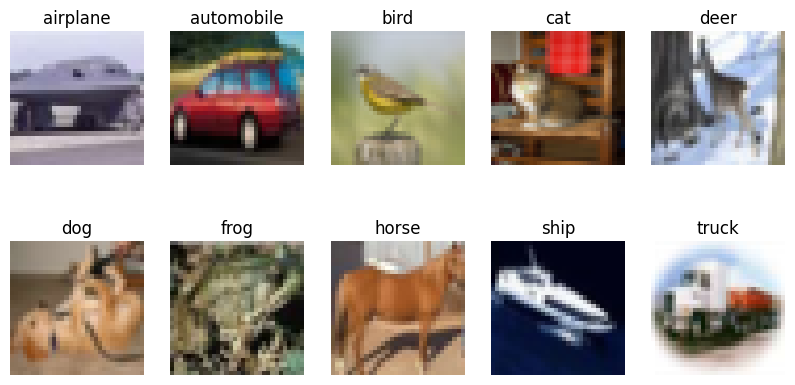

In [4]:
import matplotlib.pyplot as plt

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    while label != i-1:
        sample_idx = torch.randint(len(trainset), size=(1,)).item()
        img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

##### c) Split the trainset into training set and validation set with 90% : 10% ratio. Implement dataloaders for CIFAR10.

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, classes):
        self.data = []
        self.targets = []

        for data, target in dataset:
            if target in classes:
                self.data.append(data)
                label = 1 if target==classes[0] else -1
                self.targets.append(label)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.targets[idx])

In [7]:
def Select_Class(trainset, testset, classes=[3, 5], batch=64):
    custom_trainset = CustomImageDataset(trainset, classes)
    custom_testset = CustomImageDataset(testset, classes)

    val_ratio = 0.1
    train_size = len(custom_trainset)

    split = int(val_ratio * train_size)

    train_dataset, val_dataset = random_split(custom_trainset, [train_size-split, split])

    custom_train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    custom_val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)
    custom_test_dataloader = DataLoader(custom_testset, batch_size=batch, shuffle=True)

    return custom_train_dataloader, custom_val_dataloader, custom_test_dataloader

##### d) Choose any two classes. Then, make a SVM classifier (implement a loss function yourself. Do not use PyTorch implementations of loss functions.) and its training/validation/evaluation code to perform binary classification between those two classes.


1. Using "cuda" device for fast processing

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


2. Convert the multi-class dataset into a binary classification dataset. Then, execute the dataset with a mini-batch size of 64.

In [9]:
train_dataloader_, val_dataloader_, test_dataloader_ = Select_Class(trainset, testset, [6, 7], 64)

3. Implement Soft-margin SVM for binary dataset

In [10]:
import torch.nn as nn
import torch.optim as optim

In [11]:
class SVC(nn.Module):
    def __init__(self):
        super(SVC, self).__init__()
        self.linear = nn.Linear(3*32*32, 1)
        self.C = 1

    def forward(self, X):
        Y = self.linear(X)
        return Y

    def hinge_loss(self, Y, y):
        return torch.clamp(1-y*Y, min=0)

    def fit(self, train_dataloader, optimethod="SGD",learning_rate=0.01, epochs=10, gamma=1):
        self.C = gamma
        total_loss = 0
        n_iter, n_loss = [], []

        if optimethod:
            assert optimethod in ["SGD", "Adam"], "You should pick optimizer one of \"SGD\" or \"Adam\""
            if optimethod == "SGD":
                optimizer = optim.SGD(self.parameters(), lr=learning_rate)
            elif optimethod == "Adam":
                optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        print(f'Start training SVM model with [epoch: {epochs}, learning_rate: {learning_rate}, optimizer: {optimethod}, gamma: {gamma}]\n')

        # Here is Training Algorithm per epoch
        self.train()
        for epoch in range(epochs):
            for X, y in train_dataloader:
                # X, y = X.to(device), y.to(device)
                X = torch.flatten(X, 1, -1)
                y = torch.where(y == y.unique()[0], 1, -1)
                Y = self(X).squeeze()
                loss = torch.mean(self.hinge_loss(Y, y)) + 0.5 / self.C * torch.norm(self.linear.weight, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                total_loss += loss
            total_loss = total_loss / len(train_dataloader)
            n_iter.append(epoch+1)
            n_loss.append(total_loss.item())
            print(f'epoch: [{epoch+1}/{epochs}] -> loss: {total_loss:.3f}')
        train_accuracy = self.predict(train_dataloader)[1].item()
        print(f'\nTraining is finished.\n')
        print(f'* Final loss: {total_loss:.3f}\n* Train accuracy: {train_accuracy:.2f}%')

        # For draw graph about loss
        return n_iter, n_loss, train_accuracy

    def predict(self, test_dataloader):
        with torch.no_grad():
            total_loss = 0
            accuracy = 0
            count = 0
            self.eval()
            for X, y in test_dataloader:
                X = torch.flatten(X, 1, -1)
                y = torch.where(y == y.unique()[0], 1, -1)
                Y = self(X).squeeze()
                loss = torch.mean(self.hinge_loss(Y, y)) + 0.5 / self.C * torch.norm(self.linear.weight, p=2)
                total_loss += loss
                Y_pred = torch.where(Y < 0, -1, 1)
                accuracy += (Y_pred==y).sum()
                count += len(Y_pred==y)
            total_loss = total_loss / len(test_dataloader)
            total_accuracy = 100 * accuracy / count
        return total_loss, total_accuracy

In [12]:
svc = SVC()

epochs, losses, _ = svc.fit(train_dataloader_, learning_rate=0.001, optimethod="Adam", epochs=1, gamma=5)

Start training SVM model with [epoch: 1, learning_rate: 0.001, optimizer: Adam, gamma: 5]



epoch: [1/1] -> loss: 0.766

Training is finished.

* Final loss: 0.766
* Train accuracy: 77.64%


In [13]:
val_loss, val_acc = svc.predict(val_dataloader_)

In [14]:
print("Evaluate validation dataset loss/accuracy")
print(f'* val loss: {val_loss:.3f}\n* val accuracy: {val_acc:.2f}%')

Evaluate validation dataset loss/accuracy
* val loss: 0.643
* val accuracy: 78.40%


In [15]:
test_loss, test_acc = svc.predict(test_dataloader_)

In [16]:
print("Evaluate test dataset loss/accuracy")
print(f'* test loss: {test_loss:.3f}\n* test accuracy: {test_acc:.2f}%')

Evaluate test dataset loss/accuracy
* test loss: 0.596
* test accuracy: 81.05%


##### e) Train for 10 epochs with batch size 64.

In [17]:
svc = SVC()

epochs, losses, _ = svc.fit(train_dataloader_, learning_rate=0.001, optimethod="Adam", epochs=10, gamma=5)

Start training SVM model with [epoch: 10, learning_rate: 0.001, optimizer: Adam, gamma: 5]



epoch: [1/10] -> loss: 0.775
epoch: [2/10] -> loss: 0.649
epoch: [3/10] -> loss: 0.628
epoch: [4/10] -> loss: 0.624
epoch: [5/10] -> loss: 0.606
epoch: [6/10] -> loss: 0.608
epoch: [7/10] -> loss: 0.615
epoch: [8/10] -> loss: 0.604
epoch: [9/10] -> loss: 0.606
epoch: [10/10] -> loss: 0.607

Training is finished.

* Final loss: 0.607
* Train accuracy: 82.21%


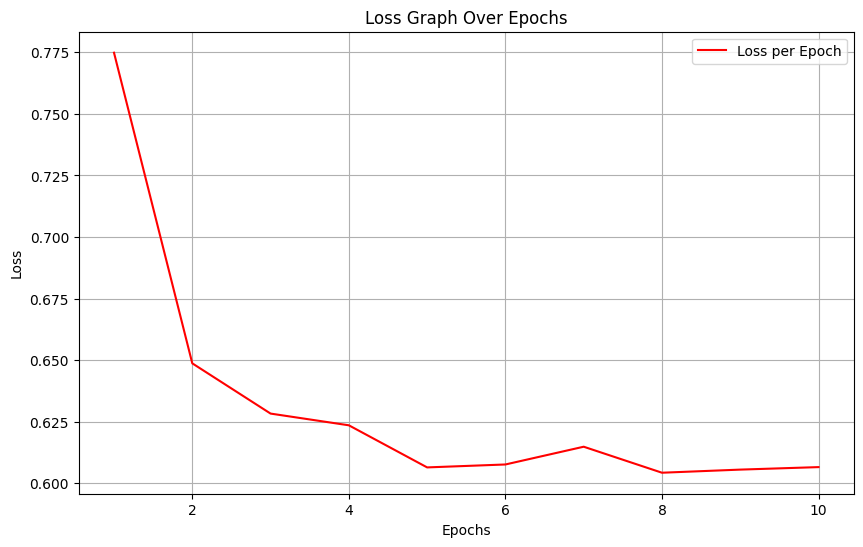

In [18]:
with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label='Loss per Epoch', color='red')
    plt.title('Loss Graph Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##### f) Perform data normalization. You may need to look into how to use datasets in PyTorch.

In [19]:
def Normalize_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    return trainset, testset

normalized_trainset, normalized_testset = Normalize_dataset()
normalized_train_dataloader, normalized_val_dataloader, normalized_test_dataloader = Select_Class(normalized_trainset, normalized_testset, [6, 7])

##### g) Again, train for 10 epochs with batch size 64 after data normalization. Write down your observations.

In [20]:
svc = SVC()

epochs, norm_losses, _ = svc.fit(normalized_train_dataloader, learning_rate=0.001, optimethod="Adam", epochs=10, gamma=5)

Start training SVM model with [epoch: 10, learning_rate: 0.001, optimizer: Adam, gamma: 5]

epoch: [1/10] -> loss: 0.622
epoch: [2/10] -> loss: 0.548
epoch: [3/10] -> loss: 0.528
epoch: [4/10] -> loss: 0.535
epoch: [5/10] -> loss: 0.523
epoch: [6/10] -> loss: 0.530
epoch: [7/10] -> loss: 0.527
epoch: [8/10] -> loss: 0.532
epoch: [9/10] -> loss: 0.529
epoch: [10/10] -> loss: 0.528

Training is finished.

* Final loss: 0.528
* Train accuracy: 84.37%


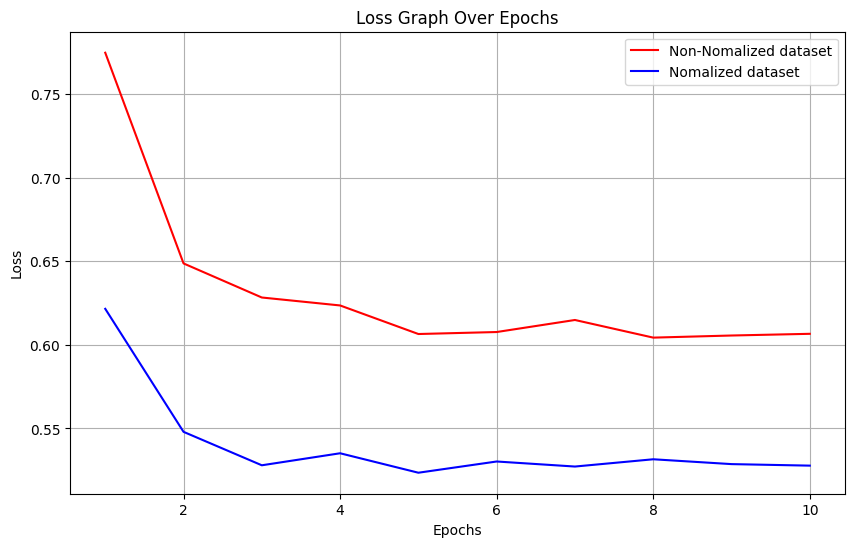

In [21]:
with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, color="red", label='Non-Nomalized dataset')
    plt.plot(epochs, norm_losses, color="blue", label='Nomalized dataset')
    plt.title('Loss Graph Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##### h) What are the hyperparameters you can tune?

1. optimizer
2. epoch
3. mini batch
4. learning rate
5. gamma

##### i) Try to obtain find optimal hyperparameters.

In [22]:
def Normalize_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    return trainset, testset

normalized_trainset, normalized_testset = Normalize_dataset()

In [23]:
# Hyperparameter: epoch, batch size, learning rate, optimizer, γ(gamma for regulization)
HPT_Visualize = {}
train_loss_Visualize = {}

optim_list = ["SGD", "Adam"]
epoch_list = [10, 20, 30]
batch_list = [32, 64, 128, 256]
lr_list = [0.01, 0.005, 0.001, 0.0005, 0.0001]
gamma_list = [0.1, 1, 10]

for op in optim_list:
    for batch in batch_list:
        normalized_train_dataloader, normalized_val_dataloader, normalized_test_dataloader = Select_Class(normalized_trainset, normalized_testset, [6, 7], batch=batch)
        for epoch in epoch_list:
            for lr in lr_list:
                for gamma in gamma_list:
                    svc = SVC()
                    _, train_loss, train_acc = svc.fit(normalized_train_dataloader, op, lr, epoch, gamma)
                    val_loss, val_acc = svc.predict(normalized_val_dataloader)
                    key = op+"_"+str(epoch)+"_"+str(batch)+"_"+str(lr)+"_"+str(gamma)
                    HPT_Visualize[key] = {"train_loss":train_loss[-1],
                                          "train_acc":train_acc,
                                          "val_loss":val_loss,
                                          "val_acc":val_acc}
                    train_loss_Visualize[key] = train_loss

Start training SVM model with [epoch: 10, learning_rate: 0.01, optimizer: SGD, gamma: 0.1]

epoch: [1/10] -> loss: 1.252
epoch: [2/10] -> loss: 1.191
epoch: [3/10] -> loss: 1.187
epoch: [4/10] -> loss: 1.178
epoch: [5/10] -> loss: 1.200
epoch: [6/10] -> loss: 1.178
epoch: [7/10] -> loss: 1.185
epoch: [8/10] -> loss: 1.179
epoch: [9/10] -> loss: 1.177
epoch: [10/10] -> loss: 1.188

Training is finished.

* Final loss: 1.188
* Train accuracy: 63.77%
Start training SVM model with [epoch: 10, learning_rate: 0.01, optimizer: SGD, gamma: 1]

epoch: [1/10] -> loss: 0.821
epoch: [2/10] -> loss: 0.765
epoch: [3/10] -> loss: 0.769
epoch: [4/10] -> loss: 0.771
epoch: [5/10] -> loss: 0.767
epoch: [6/10] -> loss: 0.765
epoch: [7/10] -> loss: 0.770
epoch: [8/10] -> loss: 0.764
epoch: [9/10] -> loss: 0.767
epoch: [10/10] -> loss: 0.769

Training is finished.

* Final loss: 0.769
* Train accuracy: 74.43%
Start training SVM model with [epoch: 10, learning_rate: 0.01, optimizer: SGD, gamma: 10]

epoch: 

In [24]:
import pandas as pd

In [25]:
DF = HPT_Visualize

In [26]:
new_data = {}
for key, value in DF.items():
    parts = key.split('_')
    optimizer, epochs, batch_size, learning_rate, Gamma = parts[:5]
    new_data[key] = {
        "optimizer": optimizer,
        "epochs": int(epochs),
        "batch size": int(batch_size),
        "learning rate": float(learning_rate),
        "Gamma": float(Gamma),
        "train_loss": value['train_loss'],
        "train_acc": value['train_acc'],
        "val_loss": float(value['val_loss']),
        "val_acc": float(value['val_acc'])
    }

df = pd.DataFrame.from_dict(new_data, orient='index')
df

,optimizer,epochs,batch size,learning rate,Gamma,train_loss,train_acc,val_loss,val_acc
SGD_10_32_0.01_0.1,SGD,10,32,0.0100,0.1,1.188030,63.766666,1.342973,61.299999
SGD_10_32_0.01_1,SGD,10,32,0.0100,1.0,0.768563,74.433334,0.847913,71.800003
SGD_10_32_0.01_10,SGD,10,32,0.0100,10.0,0.469072,84.333336,0.490246,82.099998
SGD_10_32_0.005_0.1,SGD,10,32,0.0050,0.1,1.083605,58.055557,1.280964,57.000000
SGD_10_32_0.005_1,SGD,10,32,0.0050,1.0,0.737112,79.933334,0.740328,78.000000
...,...,...,...,...,...,...,...,...,...
Adam_30_256_0.0005_1,Adam,30,256,0.0005,1.0,0.747383,80.155556,0.685605,82.300003
Adam_30_256_0.0005_10,Adam,30,256,0.0005,10.0,0.459314,85.288887,0.486874,83.599998
Adam_30_256_0.0001_0.1,Adam,30,256,0.0001,0.1,1.031242,56.366665,1.002685,57.599998
Adam_30_256_0.0001_1,Adam,30,256,0.0001,1.0,0.741019,79.300003,0.687231,81.800003


In [27]:
df_sorted = df.sort_values(by=['val_acc', 'train_acc'], ascending=False)
df_sorted.head(10)

,optimizer,epochs,batch size,learning rate,Gamma,train_loss,train_acc,val_loss,val_acc
Adam_30_32_0.0005_10,Adam,30,32,0.0005,10.0,0.457349,86.122223,0.494902,84.699997
Adam_30_256_0.001_10,Adam,30,256,0.0010,10.0,0.460588,85.288887,0.465659,84.500000
Adam_30_128_0.0005_10,Adam,30,128,0.0005,10.0,0.448505,85.744446,0.464985,84.400002
Adam_30_32_0.0001_10,Adam,30,32,0.0001,10.0,0.446705,85.144447,0.474819,84.400002
Adam_20_128_0.0005_10,Adam,20,128,0.0005,10.0,0.456162,85.311111,0.461548,84.199997
Adam_20_32_0.0001_10,Adam,20,32,0.0001,10.0,0.453965,84.511108,0.484507,84.199997
Adam_20_256_0.0001_10,Adam,20,256,0.0001,10.0,0.504064,82.066666,0.471817,84.199997
Adam_20_256_0.001_10,Adam,20,256,0.0010,10.0,0.469522,85.599998,0.464755,84.000000
Adam_30_128_0.0001_10,Adam,30,128,0.0001,10.0,0.466018,83.866669,0.469411,83.900002
Adam_30_128_0.001_10,Adam,30,128,0.0010,10.0,0.458481,85.888885,0.471658,83.800003


In [32]:
normalized_trainset, normalized_testset = Normalize_dataset()

HPT_Visualize_eval = {}
train_loss_Visualize_eval = {}

for orient in df_sorted.head(10).index:
    tl, ta, vl, va = 0, 0, 0, 0
    op, epoch, batch, lr, gamma = df_sorted.loc[orient][:5]
    normalized_train_dataloader, normalized_val_dataloader, normalized_test_dataloader = Select_Class(normalized_trainset, normalized_testset, [6, 7], batch=int(batch))
    for i in range(5):
        svc = SVC()
        _, train_loss, train_acc = svc.fit(normalized_train_dataloader, op, float(lr), int(epoch), float(gamma))
        val_loss, val_acc = svc.predict(normalized_val_dataloader)
        tl += train_loss[-1]
        ta += train_acc
        vl += val_loss
        va += val_acc
    key = op+"_"+str(epoch)+"_"+str(batch)+"_"+str(lr)+"_"+str(gamma)
    HPT_Visualize_eval[key] = {"train_loss":tl/5,
                            "train_acc":ta/5,
                            "val_loss":vl/5,
                            "val_acc":va/5}
    train_loss_Visualize_eval[key] = train_loss

Start training SVM model with [epoch: 30, learning_rate: 0.0005, optimizer: Adam, gamma: 10.0]

epoch: [1/30] -> loss: 0.589
epoch: [2/30] -> loss: 0.505
epoch: [3/30] -> loss: 0.489
epoch: [4/30] -> loss: 0.484
epoch: [5/30] -> loss: 0.475
epoch: [6/30] -> loss: 0.467
epoch: [7/30] -> loss: 0.465
epoch: [8/30] -> loss: 0.467
epoch: [9/30] -> loss: 0.464
epoch: [10/30] -> loss: 0.463
epoch: [11/30] -> loss: 0.470
epoch: [12/30] -> loss: 0.465
epoch: [13/30] -> loss: 0.462
epoch: [14/30] -> loss: 0.458
epoch: [15/30] -> loss: 0.463
epoch: [16/30] -> loss: 0.461
epoch: [17/30] -> loss: 0.458
epoch: [18/30] -> loss: 0.463
epoch: [19/30] -> loss: 0.461
epoch: [20/30] -> loss: 0.458
epoch: [21/30] -> loss: 0.462
epoch: [22/30] -> loss: 0.459
epoch: [23/30] -> loss: 0.461
epoch: [24/30] -> loss: 0.459
epoch: [25/30] -> loss: 0.460
epoch: [26/30] -> loss: 0.456
epoch: [27/30] -> loss: 0.459
epoch: [28/30] -> loss: 0.457
epoch: [29/30] -> loss: 0.456
epoch: [30/30] -> loss: 0.461

Training is 

In [33]:
final_data = {}
for key, value in HPT_Visualize_eval.items():
    parts = key.split('_')
    optimizer, epochs, batch_size, learning_rate, Gamma = parts[:5]
    final_data[key] = {
        "optimizer": optimizer,
        "epochs": int(epochs),
        "batch size": int(batch_size),
        "learning rate": float(learning_rate),
        "Gamma": float(Gamma),
        "train_loss": value['train_loss'],
        "train_acc": value['train_acc'],
        "val_loss": float(value['val_loss']),
        "val_acc": float(value['val_acc'])
    }

final_df = pd.DataFrame.from_dict(final_data, orient='index')
final_df

,optimizer,epochs,batch size,learning rate,Gamma,train_loss,train_acc,val_loss,val_acc
Adam_30_32_0.0005_10.0,Adam,30,32,0.0005,10.0,0.460622,85.557780,0.499176,82.699997
Adam_30_256_0.001_10.0,Adam,30,256,0.0010,10.0,0.458119,85.526666,0.484110,84.120003
Adam_30_128_0.0005_10.0,Adam,30,128,0.0005,10.0,0.448326,85.513333,0.483006,82.979996
Adam_30_32_0.0001_10.0,Adam,30,32,0.0001,10.0,0.444680,85.122224,0.504102,82.220001
Adam_20_128_0.0005_10.0,Adam,20,128,0.0005,10.0,0.452922,84.960002,0.501429,82.419998
Adam_20_32_0.0001_10.0,Adam,20,32,0.0001,10.0,0.454945,84.295557,0.475886,83.260002
Adam_20_256_0.0001_10.0,Adam,20,256,0.0001,10.0,0.505283,82.233334,0.484881,83.699997
Adam_20_256_0.001_10.0,Adam,20,256,0.0010,10.0,0.462562,85.337776,0.474592,83.540001
Adam_30_128_0.0001_10.0,Adam,30,128,0.0001,10.0,0.467447,83.746666,0.461237,84.300003
Adam_30_128_0.001_10.0,Adam,30,128,0.0010,10.0,0.457008,85.395555,0.519682,82.159996


In [34]:
sorted_final_df = final_df.sort_values(by=['val_acc', 'train_acc'], ascending=False)
sorted_final_df

,optimizer,epochs,batch size,learning rate,Gamma,train_loss,train_acc,val_loss,val_acc
Adam_30_128_0.0001_10.0,Adam,30,128,0.0001,10.0,0.467447,83.746666,0.461237,84.300003
Adam_30_256_0.001_10.0,Adam,30,256,0.0010,10.0,0.458119,85.526666,0.484110,84.120003
Adam_20_256_0.0001_10.0,Adam,20,256,0.0001,10.0,0.505283,82.233334,0.484881,83.699997
Adam_20_256_0.001_10.0,Adam,20,256,0.0010,10.0,0.462562,85.337776,0.474592,83.540001
Adam_20_32_0.0001_10.0,Adam,20,32,0.0001,10.0,0.454945,84.295557,0.475886,83.260002
Adam_30_128_0.0005_10.0,Adam,30,128,0.0005,10.0,0.448326,85.513333,0.483006,82.979996
Adam_30_32_0.0005_10.0,Adam,30,32,0.0005,10.0,0.460622,85.557780,0.499176,82.699997
Adam_20_128_0.0005_10.0,Adam,20,128,0.0005,10.0,0.452922,84.960002,0.501429,82.419998
Adam_30_32_0.0001_10.0,Adam,30,32,0.0001,10.0,0.444680,85.122224,0.504102,82.220001
Adam_30_128_0.001_10.0,Adam,30,128,0.0010,10.0,0.457008,85.395555,0.519682,82.159996


##### j) What is the final test accuracy?

In [35]:
normalized_trainset, normalized_testset = Normalize_dataset()

normalized_train_dataloader, normalized_val_dataloader, normalized_test_dataloader = Select_Class(normalized_trainset, normalized_testset, [6, 7], batch=256)

svc = SVC()

epochs, losses, _ = svc.fit(normalized_train_dataloader, learning_rate=0.001, optimethod="Adam", epochs=30, gamma=10)

test_loss, test_acc = svc.predict(normalized_test_dataloader)

print("\nEvaluate test dataset loss/accuracy")
print(f'* test loss: {test_loss:.3f}\n* test accuracy: {test_acc:.2f}%')

Start training SVM model with [epoch: 30, learning_rate: 0.001, optimizer: Adam, gamma: 10]

epoch: [1/30] -> loss: 0.694
epoch: [2/30] -> loss: 0.547
epoch: [3/30] -> loss: 0.511
epoch: [4/30] -> loss: 0.494
epoch: [5/30] -> loss: 0.489
epoch: [6/30] -> loss: 0.492
epoch: [7/30] -> loss: 0.478
epoch: [8/30] -> loss: 0.476
epoch: [9/30] -> loss: 0.474
epoch: [10/30] -> loss: 0.474
epoch: [11/30] -> loss: 0.466
epoch: [12/30] -> loss: 0.463
epoch: [13/30] -> loss: 0.467
epoch: [14/30] -> loss: 0.471
epoch: [15/30] -> loss: 0.465
epoch: [16/30] -> loss: 0.462
epoch: [17/30] -> loss: 0.461
epoch: [18/30] -> loss: 0.462
epoch: [19/30] -> loss: 0.463
epoch: [20/30] -> loss: 0.457
epoch: [21/30] -> loss: 0.456
epoch: [22/30] -> loss: 0.464
epoch: [23/30] -> loss: 0.465
epoch: [24/30] -> loss: 0.462
epoch: [25/30] -> loss: 0.461
epoch: [26/30] -> loss: 0.461
epoch: [27/30] -> loss: 0.452
epoch: [28/30] -> loss: 0.466
epoch: [29/30] -> loss: 0.460
epoch: [30/30] -> loss: 0.458

Training is fin

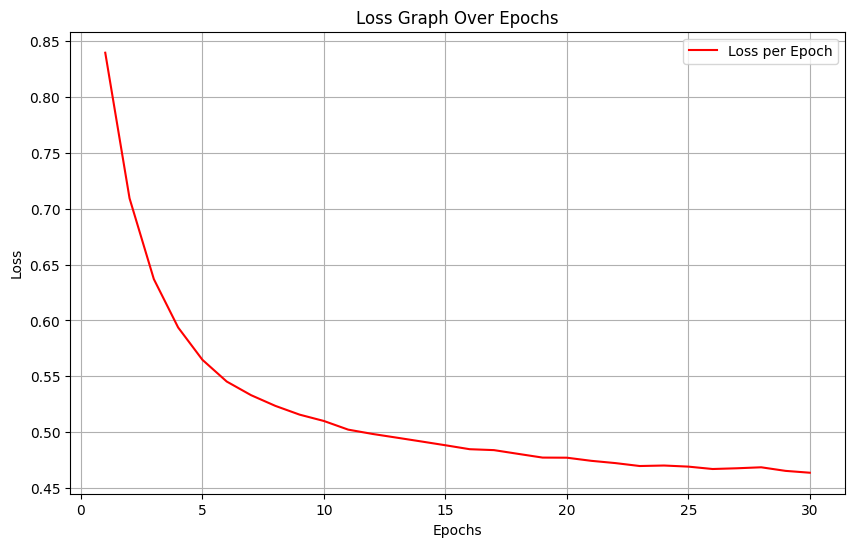

In [38]:
with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label='Loss per Epoch', color='red')
    plt.title('Loss Graph Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()